In [13]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.api import ai_client
from src.utils import *
from src.const import *
from src.plots import *
from src.signal_providers.signal_manager import *
from src.news_providers.news_api_provider import *
from src.agents.news_filtering_agent import *
from src.agents.trading_agent import *

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
coin = "ETH"

cutoff = subtract_time(get_current_datetime(), days=20)
str(cutoff)

'2024-04-01 02:38:36.616846'

In [15]:
day_history = get_day_history(coin, cutoff)
week_history = get_week_history(coin, cutoff)
month_history = get_month_history(coin, cutoff)
year_history = get_year_history(coin, cutoff)

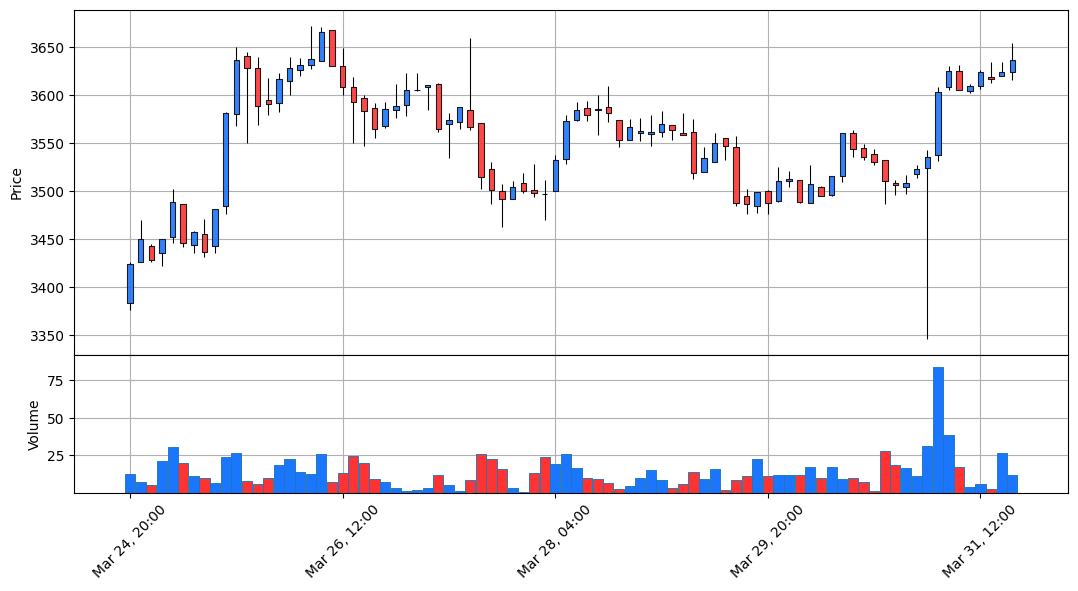

In [16]:
make_candlebars(week_history)

In [17]:
napi = NewsApi()
trading_agent = TradingAgent()
filtering_agent = NewsFilteringAgent()

In [18]:
news = napi.get_news(coin, start_date=subtract_time(cutoff, days=10), end_date=cutoff)
filtered_news = filtering_agent.filter_news(news)
json.loads(filtered_news)

{'headlines': 'Ethereum rallies amid regulatory challenges; Crypto markets see volatility as Bitcoin and Ethereum brace for more swings',
 'sentiment': 'Mixed',
 'description': 'The cryptocurrency market experienced significant volatility over the past week, with Ethereum (ETH) facing multiple regulatory challenges from the U.S. Securities and Exchange Commission (SEC). Despite these challenges, Ethereum showed signs of recovery, hinting at potential market resilience. On the regulatory front, the SEC has been especially active, investigating various platforms and the Ethereum foundation itself, questioning its compliance and influencing market sentiment. Over the week, multiple reports highlighted fluctuations in cryptocurrency prices, with Ethereum and Bitcoin witnessing sharp movements due to investor reactions to regulatory news and market uncertainty. Meanwhile, the crypto community is closely monitoring developments and potential impacts on broader market trends.'}

In [19]:
balance = {coin: 0, "USDT": 100}
operations_history = []

[{'role': 'system', 'content': 'You are professional trader.\n            You have deep knowledge of cryptocurrencies and trading markets, and you can maximize profits the most efficiently.\n            You trade in USDT.\n            \n            You an only buy or sell at the current price, you can not set stop loss.\n            Avoid spending all money in one deal, play smart.\n            \n            Respond with json of this format: \n            {\n                \'description\': what you see on charts, general short and long term trends, \n                \'trend_analysys\': rough prediction of near future development of coin,\n                \'techical_analysys\': visual technical analysis of plot and indicators,\n                \'optimal_strategy": optimal trading strategy to maximize profits in this situation,\n                \'final_decision\': what to do, possible variants: \'sell\', \'buy\', \'hold\' (do nothing),\n                \'amount\': amount of coin to buy 
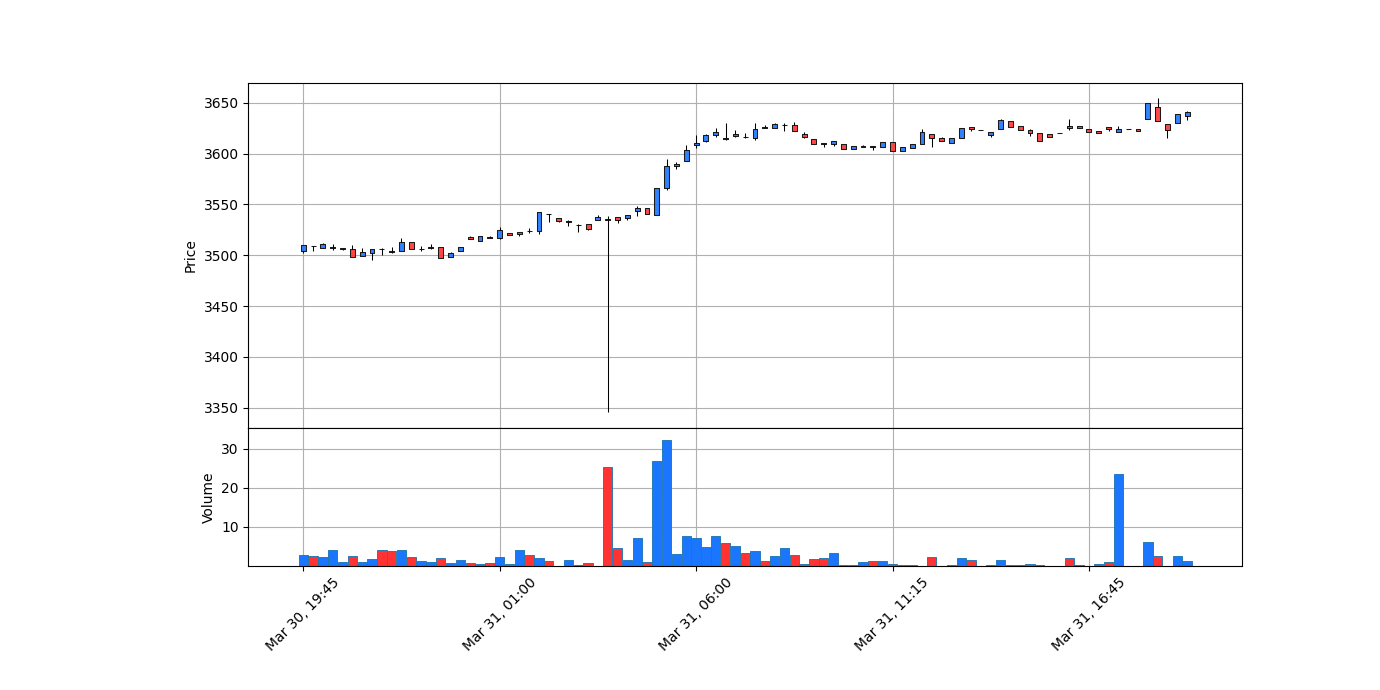
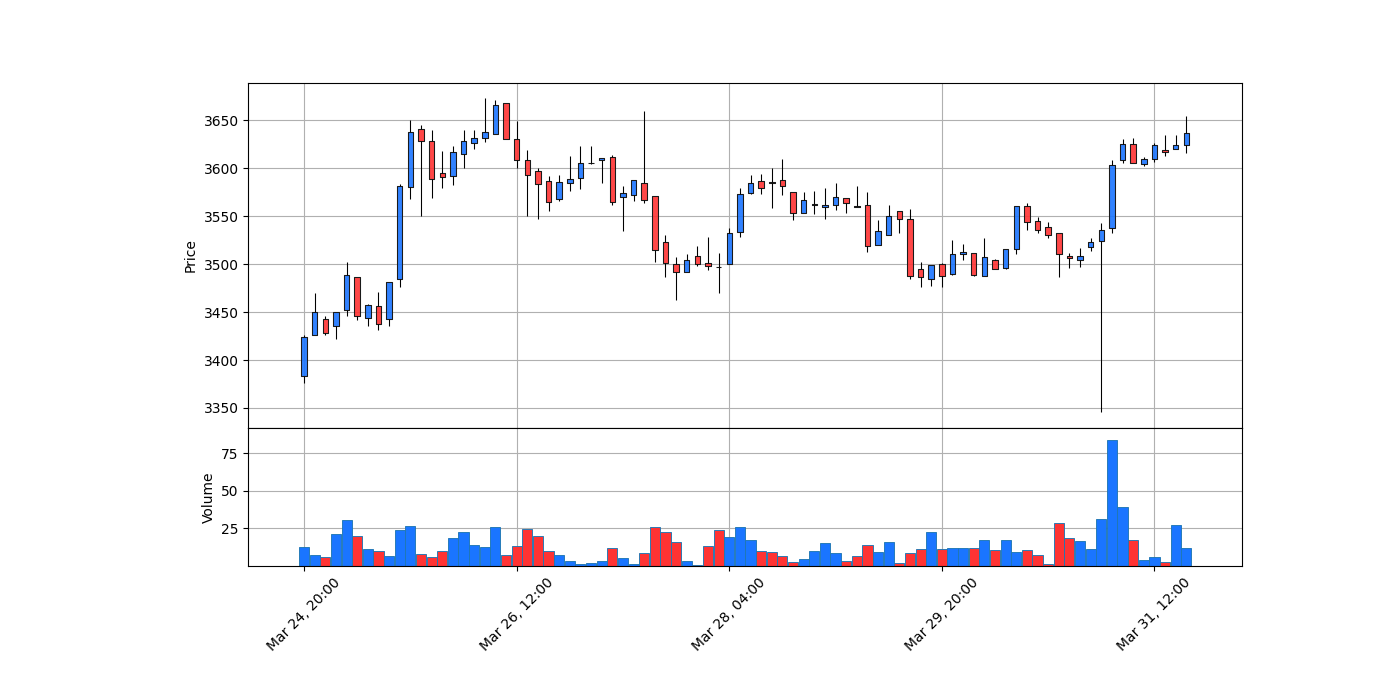
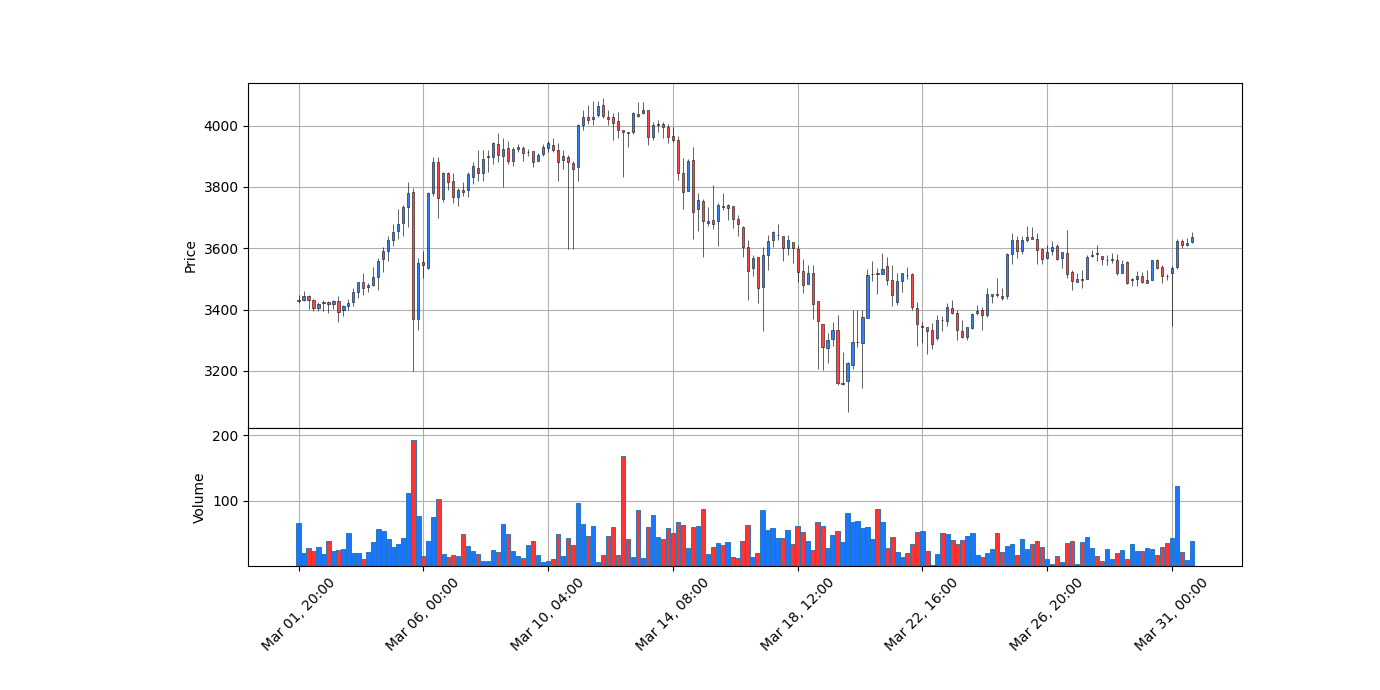
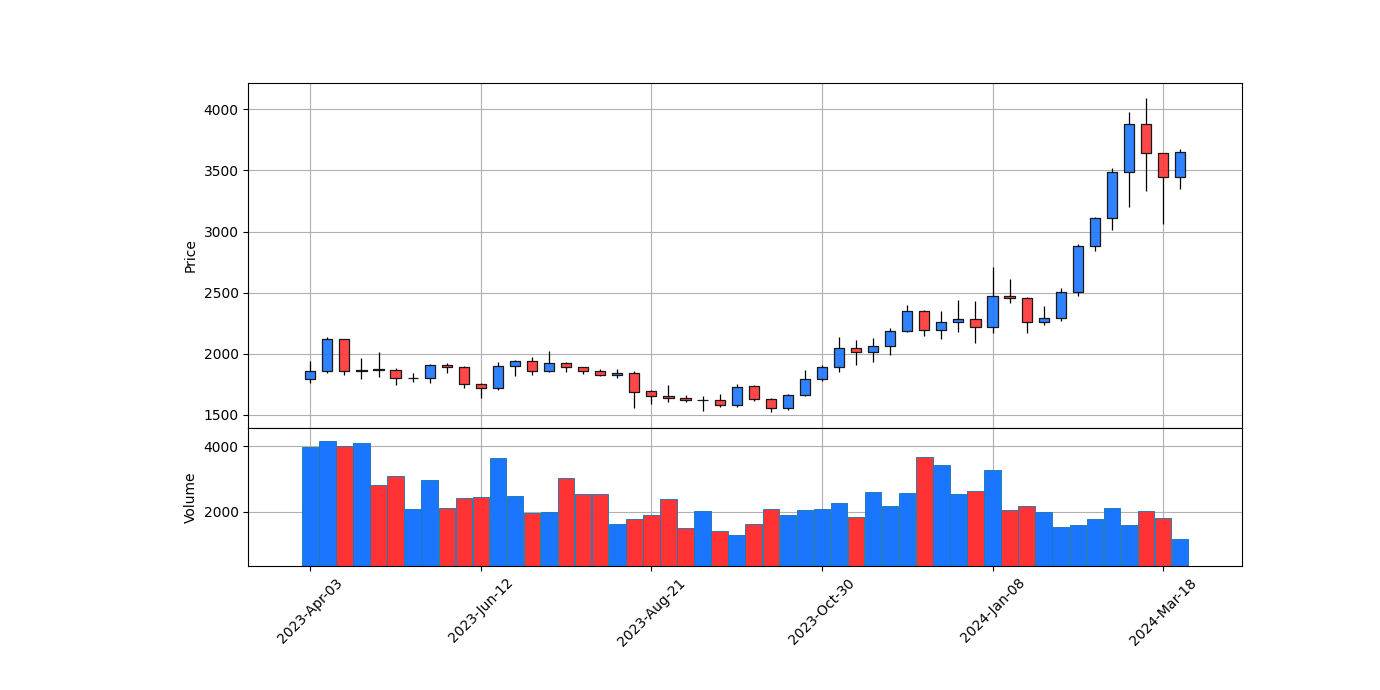

{'description': 'Analyzing the provided historical price data for Ethereum (ETH), it shows a notable upward trend over the past year with some volatility in the short term. Looking at the daily, weekly, monthly, and yearly charts, there is a consistent increase in price, especially prominent in the last couple of months. The recent news indicates mixed sentiments due to regulatory challenges which typically introduce volatility.',
 'trend_analysis': 'Ethereum has displayed resilience in the face of regulatory scrutiny, suggesting strong market fundamentals and potential recovery even after dips. Short-term rallies and corrections might continue due to ongoing market uncertainties influenced by regulatory news.',
 'technical_analysis': "The price recently made a new high in the last day and maintained most of its gains, which could be a sign of strength. There's an increased volume observed recently, indicating heightened activity that might continue to influence Ethereum’s price.",
 'o

In [21]:
predict = trading_agent.decide(
    coin=coin,
    news=filtered_news,
    day_data=day_history,
    week_data=week_history,
    month_data=month_history,
    year_data=year_history,
    operations_history=operations_history,
    current_balance=balance,
    verbose=True,
)

result = json.loads(predict)
result

In [22]:
def update_history(balance, operations_history, result):
    if result["final_decision"] == "buy":
        balance[coin] += float(result["amount"])
        balance["USDT"] -= float(result["usdt_amount"])
        operations_history.append(
            {"action": "buy", "amount": result["amount"], "price": result["price"], "date": str(cutoff)}
        )

    if result["final_decision"] == "sell":
        balance[coin] -= float(result["amount"])
        balance["USDT"] += float(result["usdt_amount"])
        operations_history.append(
            {"action": "sell", "amount": result["amount"], "price": result["price"], "date": str(cutoff)}
        )

In [23]:
update_history(balance, operations_history, result)
print(balance, operations_history)

{'ETH': 0.01375, 'USDT': 50.0} [{'action': 'buy', 'amount': 0.01375, 'price': 3641.18, 'date': '2024-04-01 02:38:36.616846'}]


In [36]:
balance = {coin: 0, "USDT": 1000}
operations_history = []
cutoff = subtract_time(get_current_datetime(), days=20)

results = []

In [39]:
def run_simulation():
    print("Running at: " + str(cutoff))
    day_history = get_day_history(coin, cutoff)
    week_history = get_week_history(coin, cutoff)
    month_history = get_month_history(coin, cutoff)
    year_history = get_year_history(coin, cutoff)

    news = napi.get_news(
        coin, start_date=subtract_time(cutoff, days=10), end_date=cutoff
    )
    filtered_news = filtering_agent.filter_news(news)

    predict = trading_agent.decide(
        coin=coin,
        news=filtered_news,
        day_data=day_history,
        week_data=week_history,
        month_data=month_history,
        year_data=year_history,
        operations_history=operations_history,
        current_balance=balance,
        verbose=False,
    )

    result = json.loads(predict)
    results.append(result)
    
    update_history(balance, operations_history, result)
    print(balance, operations_history)

In [40]:
for x in range(20):
    run_simulation()
    cutoff = add_time(cutoff, days=1)

Running at: 2024-04-01 02:51:56.136848
{'ETH': 0.055, 'USDT': 800.0} [{'action': 'buy', 'amount': 0.055, 'price': 3636.9, 'date': '2024-04-01 02:51:56.136848'}]
Running at: 2024-04-02 02:51:56.136848
{'ETH': 0.093, 'USDT': 600.0} [{'action': 'buy', 'amount': 0.055, 'price': 3636.9, 'date': '2024-04-01 02:51:56.136848'}, {'action': 'buy', 'amount': 0.038, 'price': 3483.62, 'date': '2024-04-02 02:51:56.136848'}]
Running at: 2024-04-03 02:51:56.136848
{'ETH': 0.111, 'USDT': 541.0} [{'action': 'buy', 'amount': 0.055, 'price': 3636.9, 'date': '2024-04-01 02:51:56.136848'}, {'action': 'buy', 'amount': 0.038, 'price': 3483.62, 'date': '2024-04-02 02:51:56.136848'}, {'action': 'buy', 'amount': 0.018, 'price': 3281.34, 'date': '2024-04-03 02:51:56.136848'}]
Running at: 2024-04-04 02:51:56.136848
{'ETH': 0.111, 'USDT': 541.0} [{'action': 'buy', 'amount': 0.055, 'price': 3636.9, 'date': '2024-04-01 02:51:56.136848'}, {'action': 'buy', 'amount': 0.038, 'price': 3483.62, 'date': '2024-04-02 02:51:5

KeyboardInterrupt: 

In [41]:
results

[{'description': "The analysis involves multiple time frames of ETH's price history over the day, week, month, and year. The day chart shows a relatively stable price with minor fluctuations but an uptrend for the day. The week chart shows some dips but overall maintains around the $3550-$3650 range, suggesting moderate volatility but a general upward trend toward the end of the week. The monthly chart indicates more significant volatility with a broad range from approximately $3200 to $3800. Over the year, there has been substantial growth from below $2000 to current levels with consistent volume activity, highlighting strong market participation.",
  'trend_analysis': 'Short-term: Upward trend as indicated by day and week charts. Medium-term: Some volatility with a slight bullish bias seen in the monthly chart. Long-term: Strong bullish trend as seen over the year.',
  'technical_analysis': 'Current price actions near the upper range of the weekly price movement. The market seems to 